In [20]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [32]:
class inv_Tracker():
    """Simula el detector Pixel del CMS en el HL-LHC.
    
        Args:
            
            r_max: distancia en la coordenada radial del último detector
            r_min: distancia en la coordenada radial del primer detector
            r_paso: distancia entre detectores
            h: longitud en el eje Z del Pixel
    """
    def __init__(self,r_min,r_max,h):
        self.r_min=r_min #2.5
        self.r_max=r_max #10
        r_paso=(self.r_max-self.r_min)/3
        self.h=h #60

    def detects(self, trayec, point, traza):
        """Proporciona los puntos de corte de la traza dada con el detector i.
            Cordenadas cilíndricas: (phi, z, detector)
            
            Args:
            
                trayec: Vector director de la traza(phi,z), se toma ese punto como si estuviera en el último
                anillo de detección: (phi, z, 4).
                point: Punto de partida de la traza en la dirección del beam (z), que en nuestro vector sería 
                (*,z,0)
                traza: numerador de traza, para posterior análisis
                
            Returns:
            
                coord: Matriz con los hits en cada detector. Se incluye error en phi y z.(phi,z,detector),
                el error muestra la incapacidad de calcular el punto exacto por el que pasa la traza, hay que añadir
                la distribución que tendría en la realidad.
        """
       
        coord = np.zeros( (4, 4) ) # (phi, z, detector, nº traza)
        for k in range(4):
            error=np.random.normal(0,0.01,2)
            
            coord[k][0]=trayec[0]+error[0]
            coord[k][1]=point+(trayec[1]-point)/self.r_max*(self.r_min+r_paso*k)
            coord[k][2]=k+1
            coord[k][3]=traza+1
            
        return coord

In [74]:
class Event():
    
    """ Simula un evento en el Pixel de manera aleatoria.
        
        Args:
            
            num: número de trazas forman el evento
            ruido: valor entre 0 y 1 que determine la cantidad de ruido
            
        
        
    """
    
    
    def __init__(self, num, ruido):
        
        self.num=num
        self.ruido=ruido
        global r_min
        global r_max
        global r_paso
        global h
        r_min=2.5
        r_max=10.
        r_paso=(r_max-r_min)/3
        h=60.
        global point_rand
        global trayec_rand
        global pos_ruido
        global coord
        point_rand = np.zeros( (self.num, 1) )
        trayec_rand = np.zeros( (self.num, 2) )  
        pos_ruido = np.zeros( (int(self.num*self.ruido),4) )
        coord=np.zeros( (self.num*4,4) )
        for k in range(self.num):

            point_rand[k]=0

            trayec_rand[k][0]=np.random.uniform(0,2*np.pi,1)
            trayec_rand[k][1]=np.random.normal(0,h/4,1)
            coord[int(4*k):int(4*k+4)]=inv_Tracker(r_min,r_max,h).detects(trayec_rand[k],point_rand[k],k)
            
        for i in range(int(self.num*self.ruido)):
            
            pos_ruido[i][0]=np.random.uniform(0,2*np.pi,1)
            pos_ruido[i][1]=np.random.normal(0,h/2*(1/5),1) 

            pos_ruido[i][2]=int(np.random.uniform(1,np.abs(pos_ruido[i][1]/3)+1))
       
        
    def show_event(self,abrir,cerrar,azimut,cenital):
        
        """ Muestra en un plot un intervalo del evento, en radianes. El azimut y cenital se refieren a la posición del observador.

            Args:

                abrir: inicio del intervalo en phi a estudiar
                cerrar: final del intervalo en phi a estudiar
                azimut:
                cenital:

        """
        from mpl_toolkits.mplot3d import Axes3D
        import numpy as np

        import matplotlib.pyplot as plt

        fig1 = plt.figure(figsize = (20,20)) 
        env = fig1.add_subplot(111, projection='3d') 
        # Para que no pierda las proporciones
        env.scatter([-10,-10,10,10],[-10,10,-10,10],[-h/2,-h/2,-h/2,-h/2],color='b')
        env.scatter([-10,-10,10,10],[-10,10,-10,10],[h/2,h/2,h/2,h/2],color='b')

        # DETECTORES

        for i in range(5): # El primero es el beam

            no_values = 20
            phi_cyl = np.linspace(abrir, cerrar, no_values)
            x_walls = (r_min+(i-1)*r_paso)* np.cos(phi_cyl) 
            z_walls = np.linspace(-h/2, h/2, no_values)
            x2D_walls, z2D_walls = np.meshgrid(x_walls, z_walls)
            y2D_walls = np.sqrt((r_min+(i-1)*r_paso)**2 - x2D_walls**2)


            # Detector i
            env.plot_surface(x2D_walls, -y2D_walls, z2D_walls, color='y', alpha=0.1)
            env.plot_surface(x2D_walls, y2D_walls, z2D_walls, color='y', alpha=0.1)
            env.plot_wireframe(x2D_walls, y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.05)
            env.plot_wireframe(x2D_walls, -y2D_walls, z2D_walls, rstride=1, cstride =1,color='k', alpha=0.05)

        # TRAZAS
      

        for k in range(self.num):
            
            x2=np.linspace(0,r_max*np.cos(coord[4*k][0]),30)
            y2=np.linspace(0,r_max*np.sin(coord[4*k][0]),30)
            z2=np.linspace(0,coord[4*k+3][1],30)

            env.plot(x2,y2,z2,color='m')
        # PUNTOS
        # 1) Hits
        for j in range(4*self.num):
            env.scatter((r_min+(coord[j][2]-1)*r_paso)*np.cos(coord[j][0]),(r_min+(coord[j][2]-1)*r_paso)*np.sin(coord[j][0]),coord[j][1],color='k')
        # 2) Ruido
        for k in range(int(self.num*self.ruido)):
            env.scatter((r_min+(pos_ruido[k][2]-1)*r_paso)*np.cos(pos_ruido[k][0]),(r_min+(pos_ruido[k][2]-1)*r_paso)*np.sin(pos_ruido[k][0]),pos_ruido[k][1],color='r')
        
        # REPRESENTACION

        
        env.view_init(180/np.pi*cenital, 180/np.pi*azimut)


        plt.show()

    def export_event(self):
         
        file=open('/home/pablo/Desktop/TFG/Qiskit/OutputEvent.txt', 'w')
        file.write(tabulate(np.concatenate((coord,pos_ruido)), headers=['Phi', 'z', 'Detector','Traza']))

        
        file.close()
        return file
    
    def export_hits(self):
        
        return  np.concatenate((coord,pos_ruido))

In [78]:
event=Event(70,1)

In [35]:
hits=event.export_hits()

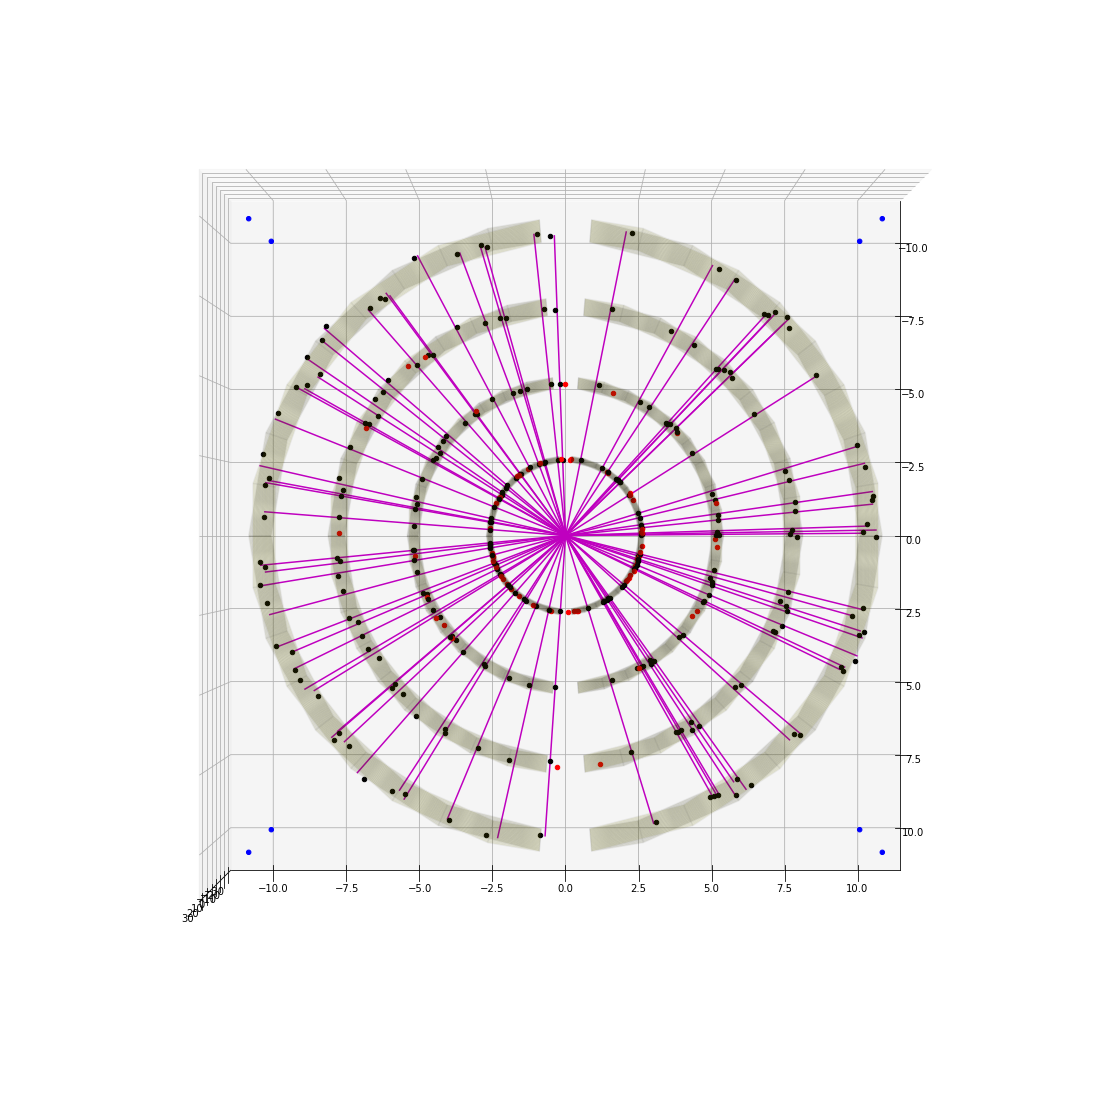

In [79]:
event.show_event(3*np.pi/2,-np.pi/2,0,np.pi/2)

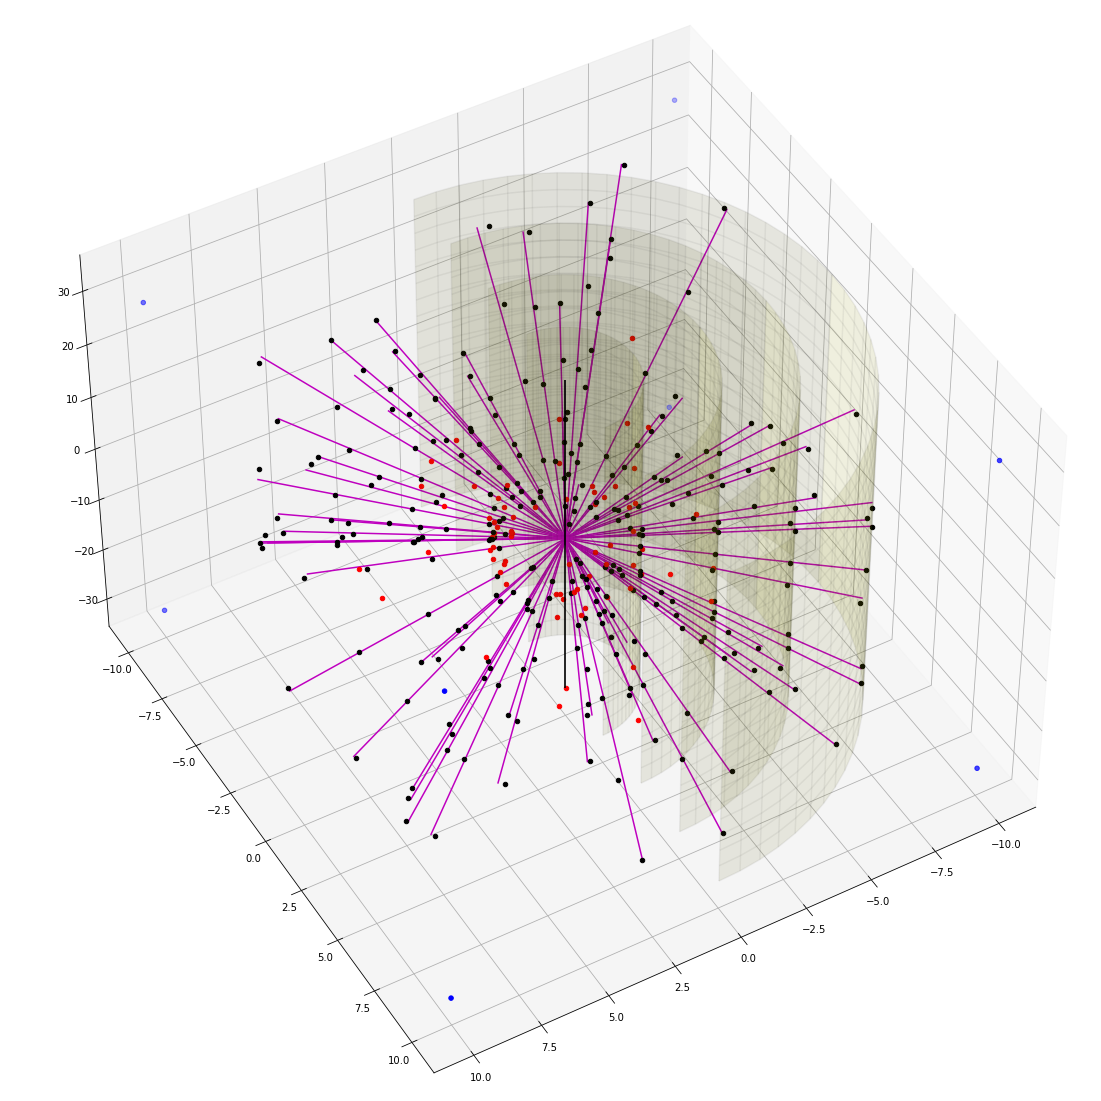

In [80]:
event.show_event(np.pi/2,np.pi,np.pi/3,np.pi/4)

In [10]:
event.export_event()

<_io.TextIOWrapper name='/home/pablo/Desktop/TFG/Qiskit/OutputEvent.txt' mode='w' encoding='UTF-8'>

In [13]:
class prepare_Event():
    """
        Args:
            OutputHits: Matriz con todos los hits del evento
            phi: angulo inicial del intervalo a estudiar, inicio de la matriz de detección
            phi: angulo final del intervalo a estudiar, fin de la matriz de detección
            matriz_deteccion: número de sensores por detector, en general serán 8: (0,1,2,3,4,5,6,7)
            
    """
    def __init__(self, OutputHits,phi_ini,phi_fin,matriz_detection):
        self.matriz_detection=matriz_detection
        self.OutputHits=OutputHits
        self.phi_ini=phi_ini
        self.phi_fin=phi_fin
        global phi_paso
        phi_paso=(phi_fin-phi_ini)/matriz_detection
        
    def show_hits(self):
        """
        De un evento dado, proporciona la información de todos los hits, indicando aquellos que se quieren estudiar y su posición en la matriz de detección
            Args:
                
            Returns: matriz  (phi, z, Detector, Traza, Indicador, Casilla), también la printea en forma de tabla
                
        """
        n=len(self.OutputHits)
        ind=np.zeros((n,1)) # Nos dice si ese hit está en el intervalo que buscamos
        cas=-np.ones((n,1)) # El estado sin utilizar es -1, cuando es un hit en el rango se indica la casiila de detección
        for k in range(n):
            if ((self.OutputHits[k][0]>self.phi_ini) and (self.OutputHits[k][0]<self.phi_fin)):
                ind[k][0]=1
                for i in range(self.matriz_detection):
                    if (self.OutputHits[k][0]<(self.phi_ini+phi_paso*(i+1))):
                        cas[k]=i
                        break
                
        data=np.append(np.append(self.OutputHits,ind,axis=1),cas,axis=1)
        print(tabulate(np.append(np.append(self.OutputHits,ind,axis=1),cas,axis=1), headers=['Phi', 'z', 'Detector','Traza','Indicador','Casilla']))
        
        

In [14]:
p=prepare_Event(hits,0,np.pi/2,8)

In [15]:
p.show_hits()

      Phi            z    Detector    Traza    Indicador    Casilla
---------  -----------  ----------  -------  -----------  ---------
0.458685    -0.665949            1        1            1          2
0.470286    -3.88676             2        1            1          2
0.444275    -7.10895             3        1            1          2
0.450546   -10.3265              4        1            1          2
3.68735     -1.42293             1        2            0         -1
3.70767     -3.44103             2        2            0         -1
3.69246     -5.46215             3        2            0         -1
3.68009     -7.48043             4        2            0         -1
3.86696      2.55784             1        3            0         -1
3.87109      3.08258             2        3            0         -1
3.85624      3.60407             3        3            0         -1
3.88188      4.12564             4        3            0         -1
3.28249      3.21525             1        4     